TensorFlow Ranking can handle heterogeneous dense and sparse features, and scales up to millions of data points. However, building and deploying a learning to rank model to operate at scale creates additional challenges beyond simply designing a model. The Ranking library provides workflow utility classes for building [distributed training](https://www.tensorflow.org/guide/distributed_training) for large-scale ranking applications. For more information about these features, see the TensorFlow Ranking [Overview](../overview).

This tutorial shows you how to build a ranking model that enables a distributed processing strategy by using the Ranking library's support for a pipeline processing architecture.

Note: An advanced version of this code is also available as a [Python script](https://github.com/tensorflow/ranking/blob/master/tensorflow_ranking/examples/keras/antique_ragged.py). The script version supports flags for hyperparameters, and advanced use-cases like [Document Interaction Network](https://research.google/pubs/pub49364).

## ANTIQUE dataset

In this tutorial, you will build a ranking model for ANTIQUE, a question-answering dataset. Given a query, and a list of answers, the objective is to rank the answers with optimal rank related metrics, such as NDCG. For more details about ranking metrics, review evaluation measures [offline metrics](https://en.wikipedia.org/wiki/Evaluation_measures_(information_retrieval)#Offline_metrics).

[ANTIQUE](https://ciir.cs.umass.edu/downloads/Antique/) is a publicly available dataset for open-domain non-factoid question answering, collected from Yahoo! answers.
Each question has a list of answers, whose relevance are graded on a scale of 0-4, 0 for irrelevant and 4 for fully relevant.
The list size can vary depending on the query, so we use a fixed "list size" of 50, where the list is either truncated or padded with default values.
The dataset is split into 2206 queries for training and 200 queries for testing. For more details, please read the technical paper on [arXiv](https://arxiv.org/abs/1905.08957).

## Setup

Download and install the TensorFlow Ranking and TensorFlow Serving packages.

Import TensorFlow Ranking library and useful libraries through the notebook.

In [1]:
import pathlib

import tensorflow as tf
import tensorflow_ranking as tfr
import tensorflow_text as tf_text
from tensorflow_serving.apis import input_pb2
from google.protobuf import text_format

## Data preparation

Download training, test data, and vocabulary file.

In [13]:
!wget -O "/tmp/train.tfrecords" "http://ciir.cs.umass.edu/downloads/Antique/tf-ranking/ELWC/train.tfrecords"
!wget -O "/tmp/test.tfrecords" "http://ciir.cs.umass.edu/downloads/Antique/tf-ranking//ELWC/test.tfrecords"
!wget -O "/tmp/vocab.txt" "http://ciir.cs.umass.edu/downloads/Antique/tf-ranking/vocab.txt"

--2022-07-05 13:58:00--  http://ciir.cs.umass.edu/downloads/Antique/tf-ranking/ELWC/train.tfrecords
Resolving ciir.cs.umass.edu (ciir.cs.umass.edu)... 128.119.246.154
Connecting to ciir.cs.umass.edu (ciir.cs.umass.edu)|128.119.246.154|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 156410796 (149M)
Saving to: ‘/tmp/train.tfrecords’

/tmp/train.tfrecord 100%[===================>] 149.16M  24.6MB/s    in 5.9s    

2022-07-05 13:58:06 (25.1 MB/s) - ‘/tmp/train.tfrecords’ saved [156410796/156410796]

--2022-07-05 13:58:06--  http://ciir.cs.umass.edu/downloads/Antique/tf-ranking//ELWC/test.tfrecords
Resolving ciir.cs.umass.edu (ciir.cs.umass.edu)... 128.119.246.154
Connecting to ciir.cs.umass.edu (ciir.cs.umass.edu)|128.119.246.154|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12432621 (12M)
Saving to: ‘/tmp/test.tfrecords’

/tmp/test.tfrecords 100%[===================>]  11.86M  13.8MB/s    in 0.9s    

2022-07-05 13:58:07 (13.8 MB/s) - ‘

Here, the dataset is saved in a ranking-specific ExampleListWithContext (ELWC) format. Detailed in the next section, shows how to generate and store data in the ELWC format.

### ELWC Data Formats for Ranking

The data for a single question consists of a list of `query_tokens` representing the question (the "context"), and a list of answers (the "examples"). Each answer is represented as a list of `document_tokens` and a `relevance` score. The following code shows a _simplified_ representation of a question's data:

In [2]:
example_list_with_context = {
    "context": {
        "query_tokens": ["this", "is", "a", "question"]
    },
    "examples": [
        {
            "document_tokens": ["this", "is", "a", "relevant", "answer"],
            "relevance": [4]
        },
        {
            "document_tokens": ["irrelevant", "data"],
            "relevance": [0]
        }
    ]
}

The data files, downloaded in the previous section, contain a serialized [protobuffer](https://developers.google.com/protocol-buffers/) representation of this sort of data.
These protobuffers are quite long when viewed as text, but encode the same data.

In [3]:
CONTEXT = text_format.Parse(
    """
    features {
      feature {
        key: "query_tokens"
        value { bytes_list { value: ["this", "is", "a", "question"] } }
      }
    }""", tf.train.Example())

In [4]:
EXAMPLES = [
    text_format.Parse(
    """
    features {
      feature {
        key: "document_tokens"
        value { bytes_list { value: ["this", "is", "a", "relevant", "answer"] } }
      }
      feature {
        key: "relevance"
        value { int64_list { value: 4 } }
      }
    }""", tf.train.Example()),
    text_format.Parse(
        """
    features {
      feature {
        key: "document_tokens"
        value { bytes_list { value: ["irrelevant", "data"] } }
      }
      feature {
        key: "relevance"
        value { int64_list { value: 0 } }
      }
    }""", tf.train.Example()),
]

In [5]:
ELWC = input_pb2.ExampleListWithContext()
ELWC.context.CopyFrom(CONTEXT)
for example in EXAMPLES:
    example_features = ELWC.examples.add()
    example_features.CopyFrom(example)

print(ELWC)

examples {
  features {
    feature {
      key: "document_tokens"
      value {
        bytes_list {
          value: "this"
          value: "is"
          value: "a"
          value: "relevant"
          value: "answer"
        }
      }
    }
    feature {
      key: "relevance"
      value {
        int64_list {
          value: 4
        }
      }
    }
  }
}
examples {
  features {
    feature {
      key: "document_tokens"
      value {
        bytes_list {
          value: "irrelevant"
          value: "data"
        }
      }
    }
    feature {
      key: "relevance"
      value {
        int64_list {
          value: 0
        }
      }
    }
  }
}
context {
  features {
    feature {
      key: "query_tokens"
      value {
        bytes_list {
          value: "this"
          value: "is"
          value: "a"
          value: "question"
        }
      }
    }
  }
}



While the text format is verbose, protos can be efficiently serialized to a byte string (and parsed back into a proto)

In [6]:
serialized_elwc = ELWC.SerializeToString()
print(serialized_elwc)

b"\nL\nJ\n4\n\x0fdocument_tokens\x12!\n\x1f\n\x04this\n\x02is\n\x01a\n\x08relevant\n\x06answer\n\x12\n\trelevance\x12\x05\x1a\x03\n\x01\x04\n?\n=\n'\n\x0fdocument_tokens\x12\x14\n\x12\n\nirrelevant\n\x04data\n\x12\n\trelevance\x12\x05\x1a\x03\n\x01\x00\x12-\n+\n)\n\x0cquery_tokens\x12\x19\n\x17\n\x04this\n\x02is\n\x01a\n\x08question"


The following parser configuration parses the binary representation into a dictionary of tensors:

In [7]:
def parse_elwc(elwc):
    return tfr.data.parse_from_example_list(
        [elwc],
        list_size = 2,
        context_feature_spec = {
            "query_tokens": tf.io.RaggedFeature(dtype = tf.string)
        },
        example_feature_spec = {
            "document_tokens":
                tf.io.RaggedFeature(dtype = tf.string),
            "relevance":
                tf.io.FixedLenFeature(shape = [], dtype = tf.int64, default_value = 0)
        },
        size_feature_name = "_list_size_",
        mask_feature_name = "_mask_"
    )


parse_elwc(serialized_elwc)

2022-07-05 13:57:16.315747: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


{'relevance': <tf.Tensor: shape=(1, 2), dtype=int64, numpy=array([[4, 0]])>,
 'document_tokens': <tf.RaggedTensor [[[b'this', b'is', b'a', b'relevant', b'answer'],
   [b'irrelevant', b'data']]]>,
 'query_tokens': <tf.RaggedTensor [[b'this', b'is', b'a', b'question']]>,
 '_list_size_': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([2], dtype=int32)>,
 '_mask_': <tf.Tensor: shape=(1, 2), dtype=bool, numpy=array([[ True,  True]])>}

Note with ELWC, you could also generate `size` and/or `mask` features to indicate the valid size and/or to mask out the valid entries in the list as long as `size_feature_name` and/or `mask_feature_name` are defined.

The above parser is defined in `tfr.data` and wrapped in our predefined dataset builder `tfr.keras.pipeline.BaseDatasetBuilder`.

## Overview of the ranking pipeline

Follow the steps depicted in the figure below to train a ranking model with ranking pipeline. In particular, this example uses the `tfr.keras.model.FeatureSpecInputCreator` and `tfr.keras.pipeline.BaseDatasetBuilder` defined specific for the datasets with `feature_spec`.

![TF02  TF-Ranking_ Learning-to-rank in Tensorflow](https://user-images.githubusercontent.com/18746174/136829491-1d76c2e0-6779-4b7f-9a8c-515acc17d0ec.png)


## Create a model builder

Instead of directly building a `tf.keras.Model` object, create a model_builder, which is called in the ranking pipeline to build the `tf.keras.Model`, as all training parameters must be defined under the `strategy.scope` (called in `train_and_validate` function in ranking pipeline) in order to train with distributed strategies.

This framework uses the [keras functional api](https://www.tensorflow.org/guide/keras/functional) to build models, where inputs (`tf.keras.Input`), preprocessors (`tf.keras.layers.experimental.preprocessing`), and scorer (`tf.keras.Sequential`) are required to define the model.

### Specify Features

[Feature Specification](https://www.tensorflow.org/api_docs/python/tf/io) are TensorFlow abstractions that are used to capture rich information about each feature.

Create feature specifications for context features, example features, and labels, consistent with the input formats for ranking, such as ELWC format.

The `default_value` of `label_spec` feature is set to -1 to take care of the padding items to be masked out.

In [8]:
context_feature_spec = {
    "query_tokens": tf.io.RaggedFeature(dtype=tf.string),
}
example_feature_spec = {
    "document_tokens":
        tf.io.RaggedFeature(dtype=tf.string),
}
label_spec = (
    "relevance",
    tf.io.FixedLenFeature(shape=(1,), dtype=tf.int64, default_value=-1)
)

### Define `input_creator`

`input_creator` create dictionaries of context and example `tf.keras.Input`s for input features defined in `context_feature_spec` and `example_feature_spec`.

In [9]:
input_creator = tfr.keras.model.FeatureSpecInputCreator(
    context_feature_spec, example_feature_spec)

Callling the `input_creator` returns the dictionaries of Keras-Tensors, that are used as the inputs when building the model:

In [10]:
input_creator()

({'query_tokens': <KerasTensor: type_spec=RaggedTensorSpec(TensorShape([None, None]), tf.string, 1, tf.int64) (created by layer 'query_tokens')>},
 {'document_tokens': <KerasTensor: type_spec=RaggedTensorSpec(TensorShape([None, None, None]), tf.string, 2, tf.int64) (created by layer 'document_tokens')>})

### Define `preprocessor`

In the `preprocessor`, the input tokens are converted to a one-hot vector through the String Lookup preprocessing layer and then embeded as an embedding vector through the Embedding preprocessing layer. Finally, compute an embedding vector for the full sentence by the average of token embeddings.

In [11]:
class LookUpTablePreprocessor(tfr.keras.model.Preprocessor):

    def __init__(self, vocab_file, vocab_size, embedding_dim):
        self._vocab_file = vocab_file
        self._vocab_size = vocab_size
        self._embedding_dim = embedding_dim

    def __call__(self, context_inputs, example_inputs, mask):
        list_size = tf.shape(mask)[1]
        lookup = tf.keras.layers.StringLookup(
            max_tokens = self._vocab_size,
            vocabulary = self._vocab_file,
            mask_token = None
        )
        embedding = tf.keras.layers.Embedding(
            input_dim = self._vocab_size,
            output_dim = self._embedding_dim,
            embeddings_initializer = None,
            embeddings_constraint = None
        )
        # StringLookup and Embedding are shared over context and example features.
        context_features = {
            key: tf.reduce_mean(embedding(lookup(value)), axis = -2)
            for key, value in context_inputs.items()
        }
        example_features = {
            key: tf.reduce_mean(embedding(lookup(value)), axis = -2)
            for key, value in example_inputs.items()
        }
        return context_features, example_features

In [14]:
_VOCAB_FILE = '/tmp/vocab.txt'
_VOCAB_SIZE = len(pathlib.Path(_VOCAB_FILE).read_text().split())

In [15]:
preprocessor = LookUpTablePreprocessor(_VOCAB_FILE, _VOCAB_SIZE, 20)

Note that the vocabulary uses the same tokenizer that BERT does. You could also use [BertTokenizer](https://www.tensorflow.org/text/guide/subwords_tokenizer) to tokenize the raw sentences.

In [16]:
tokenizer = tf_text.BertTokenizer(_VOCAB_FILE)
example_tokens = tokenizer.tokenize("Hello TensorFlow!".lower())

print(example_tokens)
print(tokenizer.detokenize(example_tokens))

<tf.RaggedTensor [[[7592], [23435, 12314], [999]]]>
<tf.RaggedTensor [[[b'hello'],
  [b'tensorflow'],
  [b'!']]]>


### Define `scorer`

This example uses a Deep Neural Network (DNN) univariate scorer, predefined in TensorFlow Ranking.

In [17]:
scorer = tfr.keras.model.DNNScorer(
    hidden_layer_dims=[64, 32, 16],
    output_units=1,
    activation=tf.nn.relu,
    use_batch_norm=True)

### Make `model_builder`

In addition to `input_creator`, `preprocessor`, and `scorer`, specify the mask feature name to take the mask feature generated in datasets.

In [18]:
model_builder = tfr.keras.model.ModelBuilder(
    input_creator=input_creator,
    preprocessor=preprocessor,
    scorer=scorer,
    mask_feature_name="example_list_mask",
    name="antique_model",
)

Check the model architecture,

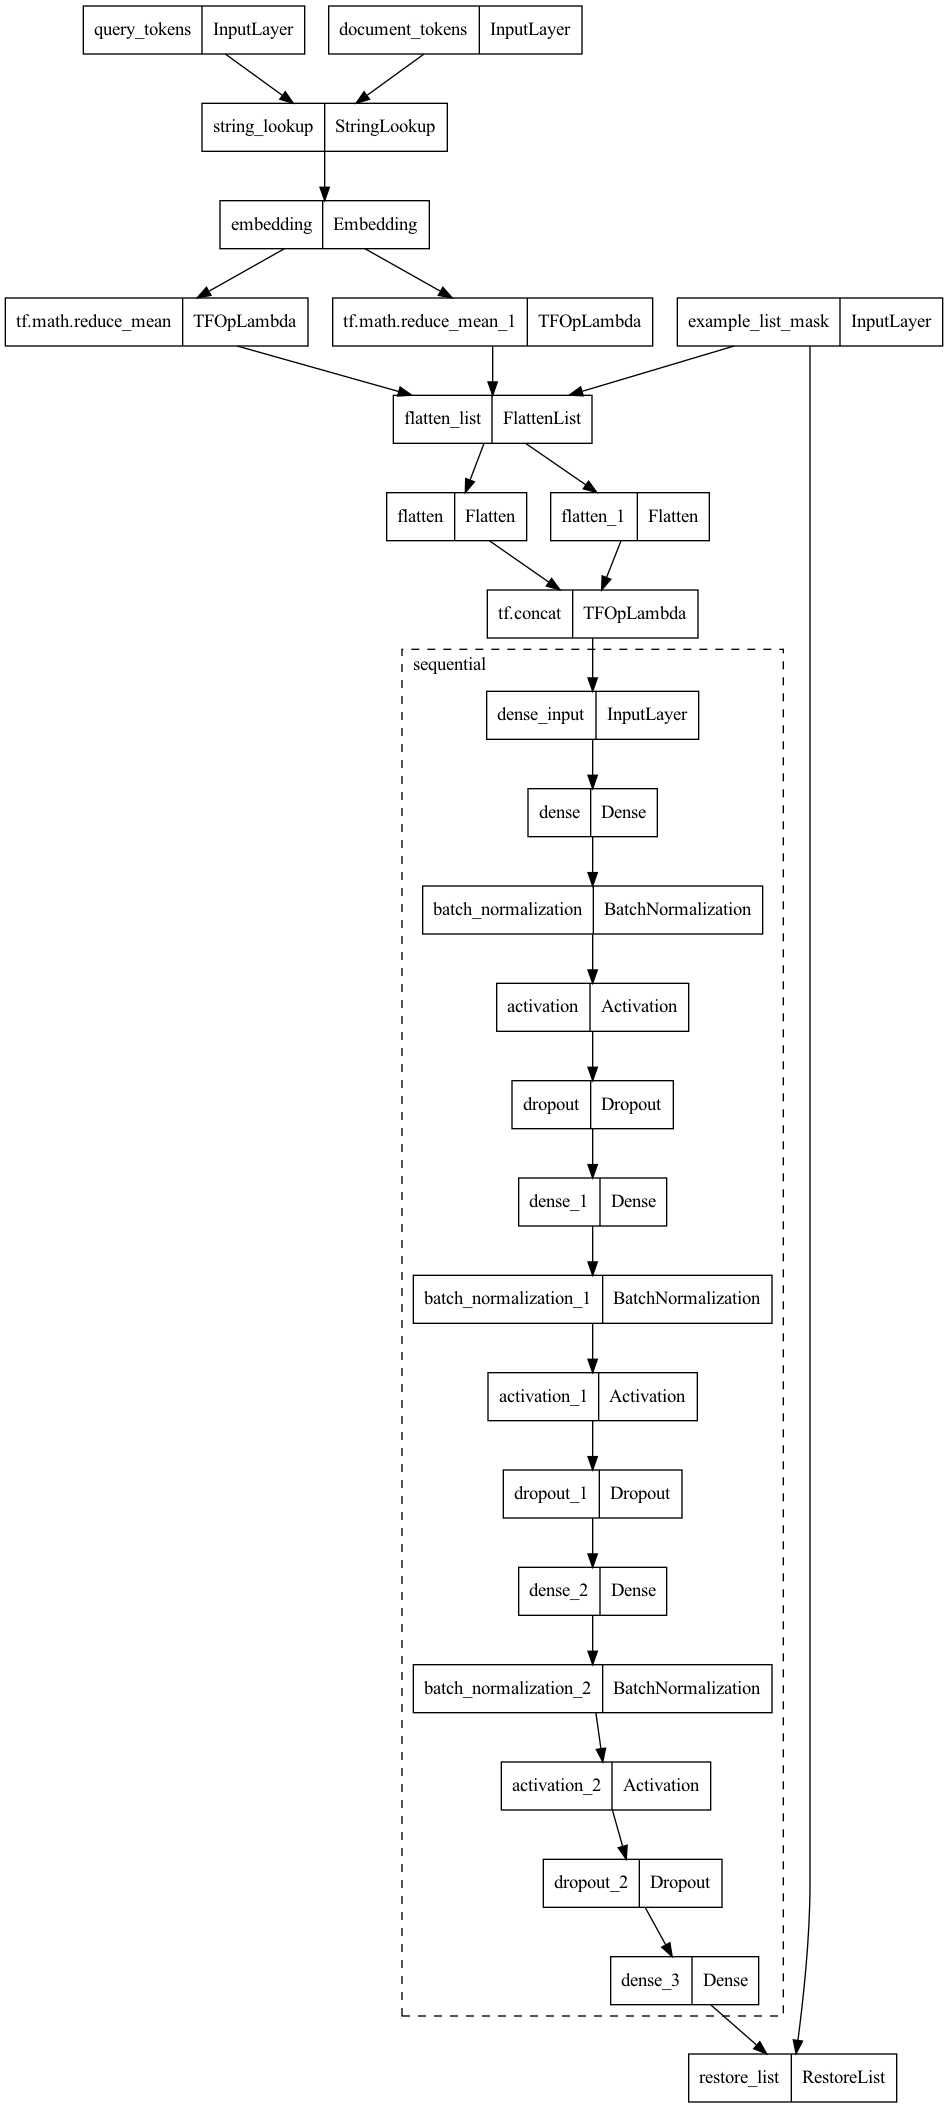

In [19]:
model = model_builder.build()
tf.keras.utils.plot_model(model, expand_nested=True)

## Create a dataset builder

A `dataset_builder` is designed to create datasets for training and validation and to define [signatures](https://www.tensorflow.org/guide/saved_model#specifying_signatures_during_export) for exporting trained model as `tf.function`. 

### Specify data hyperparameters

Define the hyperparameters to be used to build datasets in `dataset_builder` by creating a `dataset_hparams` object.

Load training dataset at `/tmp/train.tfrecords` with `tf.data.TFRecordDataset` reader. In each batch, each feature tensor has a shape `(batch_size, list_size, feature_sizes)` with `batch_size` equal to 32 and `list_size` equal to 50. Validate with the test data at `/tmp/test.tfrecords` at the same `batch_size` and `list_size`.

In [20]:
dataset_hparams = tfr.keras.pipeline.DatasetHparams(
    train_input_pattern="/tmp/train.tfrecords",
    valid_input_pattern="/tmp/test.tfrecords",
    train_batch_size=32,
    valid_batch_size=32,
    list_size=50,
    dataset_reader=tf.data.TFRecordDataset)

### Make `dataset_builder`

TensorFlow Ranking provides a pre-defined `SimpleDatasetBuilder` to generate datasets from ELWC using `feature_spec`s. As a mask feature is used to determine valid examples in each padded list, must specify the `mask_feature_name` consistent with the `mask_feature_name` used in `model_builder`.

In [21]:
dataset_builder = tfr.keras.pipeline.SimpleDatasetBuilder(
    context_feature_spec,
    example_feature_spec,
    mask_feature_name="example_list_mask",
    label_spec=label_spec,
    hparams=dataset_hparams)

In [22]:
ds_train = dataset_builder.build_train_dataset()
ds_train.element_spec

({'document_tokens': RaggedTensorSpec(TensorShape([None, 50, None]), tf.string, 2, tf.int32),
  'query_tokens': RaggedTensorSpec(TensorShape([32, None]), tf.string, 1, tf.int32),
  'example_list_mask': TensorSpec(shape=(32, 50), dtype=tf.bool, name=None)},
 TensorSpec(shape=(32, 50), dtype=tf.float32, name=None))

## Create a ranking pipeline

A `ranking_pipeline` is an optimized ranking model training package that implement distributed training, export model as `tf.function`, and integrate useful callbacks including tensorboard and restoring upon failures.

### Specify pipeline hyperparameters

Specify the hyperparameters to be used to run the pipeline in `ranking_pipeline` by creating a `pipeline_hparams` object. 

Train the model with `approx_ndcg_loss` at learning rate equal to 0.05 for 5 epoch with 1000 steps in each epoch using `MirroredStrategy`. Evaluate the model on the validation dataset for 100 steps after each epoch. Save the trained model under `/tmp/ranking_model_dir`.

In [23]:
pipeline_hparams = tfr.keras.pipeline.PipelineHparams(
    model_dir="/tmp/ranking_model_dir",
    num_epochs=5,
    steps_per_epoch=1000,
    validation_steps=100,
    learning_rate=0.05,
    loss="approx_ndcg_loss",
    strategy="MirroredStrategy")

### Define `ranking_pipeline`

TensorFlow Ranking provides a pre-defined `SimplePipeline` to support model training with distributed strategies.

In [24]:
ranking_pipeline = tfr.keras.pipeline.SimplePipeline(
    model_builder,
    dataset_builder=dataset_builder,
    hparams=pipeline_hparams)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


## Train and evaluate the model

The `train_and_validate` function evaluates the trained model on the validation dataset after every epoch.

In [25]:
ranking_pipeline.train_and_validate(verbose=1)

Epoch 1/5


2022-07-05 13:58:53.790579: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
/Users/lhuang/opt/miniconda3/envs/tensorflow2.8/lib/python3.8/site-packages/tensorflow/python/framework/indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/antique_model/flatten_list_1/RaggedGatherNd/RaggedGatherNd/RaggedGather/Reshape_1:0", shape=(1600,), dtype=int32, device=/job:localhost/replica:0/task:0/device:CPU:0), values=Tensor("gradient_tape/antique_model/flatten_list_1/RaggedGatherNd/RaggedGatherNd/RaggedGather/Reshape:0", shape=(1600, 20), dtype=float32, device=/job:localhost/replica:0/task:0/device:CPU:0), dense_shape=Tensor("gradient_tape/antique_model/flatten_list_1/RaggedGatherNd/RaggedGatherNd/RaggedGather/Cast:0", shape=(2,), dtype=int32, device=/job:localhost/replica:0/task:0/devi

1000/1000 [==============================] - 22s 22ms/step - loss: -0.8902 - metric/ndcg_1: 0.7280 - metric/ndcg_5: 0.7905 - metric/ndcg_10: 0.8483 - metric/ndcg: 0.8912 - val_loss: -0.8739 - val_metric/ndcg_1: 0.6893 - val_metric/ndcg_5: 0.7665 - val_metric/ndcg_10: 0.8321 - val_metric/ndcg: 0.8739
Epoch 2/5
1000/1000 [==============================] - ETA: 0s - loss: -0.8947 - metric/ndcg_1: 0.7423 - metric/ndcg_5: 0.7980 - metric/ndcg_10: 0.8527 - metric/ndcg: 0.8950

2022-07-05 13:59:26.579405: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


1000/1000 [==============================] - 11s 11ms/step - loss: -0.8947 - metric/ndcg_1: 0.7423 - metric/ndcg_5: 0.7980 - metric/ndcg_10: 0.8527 - metric/ndcg: 0.8950 - val_loss: -0.8680 - val_metric/ndcg_1: 0.6614 - val_metric/ndcg_5: 0.7627 - val_metric/ndcg_10: 0.8298 - val_metric/ndcg: 0.8683
Epoch 3/5
1000/1000 [==============================] - 10s 10ms/step - loss: -0.8992 - metric/ndcg_1: 0.7490 - metric/ndcg_5: 0.8062 - metric/ndcg_10: 0.8593 - metric/ndcg: 0.8993 - val_loss: -0.8751 - val_metric/ndcg_1: 0.6914 - val_metric/ndcg_5: 0.7776 - val_metric/ndcg_10: 0.8350 - val_metric/ndcg: 0.8756
Epoch 4/5
1000/1000 [==============================] - 10s 10ms/step - loss: -0.8987 - metric/ndcg_1: 0.7504 - metric/ndcg_5: 0.8053 - metric/ndcg_10: 0.8580 - metric/ndcg: 0.8988 - val_loss: -0.8593 - val_metric/ndcg_1: 0.6329 - val_metric/ndcg_5: 0.7507 - val_metric/ndcg_10: 0.8157 - val_metric/ndcg: 0.8594
Epoch 5/5
1000/1000 [==============================] - 10s 10ms/step - loss: 

2022-07-05 14:00:00.992638: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /tmp/ranking_model_dir/export/latest_model/assets


INFO:tensorflow:Assets written to: /tmp/ranking_model_dir/export/latest_model/assets


### Launch TensorBoard

In [26]:
%load_ext tensorboard
%tensorboard --logdir="/tmp/ranking_model_dir" --port 12345

<!-- <img class="tfo-display-only-on-site" src="https://user-images.githubusercontent.com/18746174/136845677-8cd41b8f-0a1a-4b38-b905-779966839e5f.png" /> -->

### Generate predictions and evaluate

Get the test data.

In [27]:
ds_test = dataset_builder.build_valid_dataset()

# Get input features from the first batch of the test data
for x, y in ds_test.take(1):
    break

Load the saved model and run a prediction.

In [28]:
loaded_model = tf.keras.models.load_model("/tmp/ranking_model_dir/export/latest_model")

In [29]:
# Predict ranking scores
scores = loaded_model.predict(x)
min_score = tf.reduce_min(scores)
scores = tf.where(tf.greater_equal(y, 0.), scores, min_score - 1e-5)

# Sort the answers by scores
sorted_answers = tfr.utils.sort_by_scores(
    scores,
    [tf.strings.reduce_join(x['document_tokens'], -1, separator=' ')])[0]

Check the top 5 answers for question number 4.

In [30]:
question = tf.strings.reduce_join(
    x['query_tokens'][4, :], -1, separator=' ').numpy()
top_answers = sorted_answers[4, :5].numpy()

print(
    f'Q: {question.decode()}\n' +
    '\n'.join([f'A{i+1}: {ans.decode()}' for i, ans in enumerate(top_answers)]))

Q: why do people ask questions they know ?
A1: human nature i guess . i have noticed that too . maybe it is just for re ##ass ##urance or approval .
A2: to rev ##ali ##date their knowledge and perhaps they choose answers that are mostly with their side simply because they are being subjective . . . .
A3: people like to that be ##cao ##use they want to be recognise that they are the one knows the answer and the questions int ##he first place .
A4: because it re ##as ##ures them that they were right in the first place .
A5: so they can weasel out the judge mental and super ##ci ##lio ##us know all cr ##aa ##p like yourself . . . don ##t judge others , what gives you the right ? . . how do you know what others know . ? . . by asking this question you are putting yourself in the same league as the others you want ot condemn . . face it you already know what your shallow , self absorbed answer is . . . get a reality check pill ##ock , . . . and if you want to go gr ##iz ##z ##ling to the ya